This notebook provides code for a PyTorch convolutional neural network which - after training - classifies people faces images in two classes: wearing a mask and not wearing it. [Dataset](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset) is taken from Kaggle - follow the complementary notebook for downloading Kaggle dataset to Google Drive.  

## Prerequisites

In [ ]:
# install PyTorch, OpenCV, Matplotlib and NumPy
!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torchsummary
!pip install numpy matplotlib opencv-python
!pip install torch torchvision

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
# import necessary libraries and functions
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [ ]:
# define paths to directories with dataset
TRAIN_DIR = "/content/gdrive/My Drive/Kaggle/mask_classification_12K/Train"
VAL_DIR = "/content/gdrive/My Drive/Kaggle/mask_classification_12K/Validation"
TEST_DIR = "/content/gdrive/My Drive/Kaggle/mask_classification_12K/Test"

In [ ]:
BATCH_SIZE=128

In [ ]:
# mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Adjusting dataset 

In [ ]:
# apply transformations on images (so that they all are the same size)

transform_train= T.Compose([
    T.Resize((64, 64)),
    T.CenterCrop(64),
    T.ToTensor()
])

transform_val = T.Compose([
    T.Resize((64,64)),
    T.ToTensor()
])

val_ds = ImageFolder(root=VAL_DIR, transform=transform_val)
train_ds = ImageFolder(root=TRAIN_DIR, transform=transform_train)

In [ ]:
# create data loaders for train set and validation set
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, BATCH_SIZE, num_workers=3, pin_memory=True)

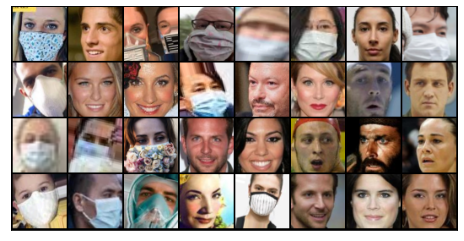

In [ ]:
# display batch
for images, labels in train_dl:
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(images[:32], nrow=8).permute(1,2,0))
  break

## Training and testing functions' definitions 

In [ ]:
# define function for a training step
def train_step(network, train_loader, epoch, device, verbose=True):
    train_losses = []
    train_counter = []
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        network.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx % log_interval == 0):
            if verbose:
                print('Train Epoch: {:5d} [{:5d}/{:5d} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, 
                    batch_idx * len(data), 
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), 
                    loss.item()))
            
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    
    return train_losses, train_counter

In [ ]:
# define function for testing
def test(network, test_loader, device, verbose=True):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    if verbose:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {:5d}/{:5d} ({:2.2f}%)\n'.format(
            test_loss, 
            correct, 
            len(test_loader.dataset),
            accuracy))
    
    return test_loss, accuracy.item()

In [ ]:
# define function for performing the training process
def train_network(network, train_loader, test_loader, device='cpu'):
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    test_accuracy = []
    test_loss, accuracy = test(network, test_loader, device)
    test_accuracy.append(accuracy)
    test_losses.append(test_loss)

    for epoch in range(1, n_epochs + 1):
        new_train_losses, new_train_counter = train_step(network, train_loader, epoch, device)
        test_loss, accuracy = test(network, test_loader, device)
        test_accuracy.append(accuracy)
        train_losses.extend(new_train_losses)
        train_counter.extend(new_train_counter)
        test_losses.append(test_loss)
        
    return train_losses, train_counter, test_losses, test_counter, test_accuracy

## Definition of the neural network structure and other training parameters

In [ ]:
# define the structure of the convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout_3 = nn.Dropout(0.3)
        self.dropout_4 = nn.Dropout(0.4)
        self.dropout_5 = nn.Dropout(0.5)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4)
        self.fc1 = nn.Linear(64*14*14, 256)
        self.fc2 = nn.Linear(256, 2)


    def forward(self, x):
        x = self.conv1(x)         # 3x64x64 -> 32x62x62
        x = self.relu(x)
        x = self.pool(x)          # 32x62x62 -> 32x31x31
        x = self.dropout_3(x)
        
        x = self.conv2(x)         # 32x31x31 -> 64x28x28
        x = self.relu(x)
        x = self.pool(x)          # 64x28x28 -> 64x14x14
        x = self.dropout_4(x)

        x = x.view(-1, 64*14*14)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout_5(x)

        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [ ]:
# learning parameters
n_epochs = 30
learning_rate = 0.01
log_interval = 33
device = 'cpu'
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

## Training

In [ ]:
# train the network
train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(network, train_dl, val_dl, device)


Test set: Avg. loss: 0.6939, Accuracy:   400/  800 (50.00%)

Train Epoch:     1 [    0/10000 ( 0%)]	Loss: 0.694012
Train Epoch:     1 [ 4224/10000 (42%)]	Loss: 0.659950
Train Epoch:     1 [ 8448/10000 (84%)]	Loss: 0.587843

Test set: Avg. loss: 0.5687, Accuracy:   627/  800 (78.38%)

Train Epoch:     2 [    0/10000 ( 0%)]	Loss: 0.566585
Train Epoch:     2 [ 4224/10000 (42%)]	Loss: 0.495961
Train Epoch:     2 [ 8448/10000 (84%)]	Loss: 0.380316

Test set: Avg. loss: 0.5507, Accuracy:   549/  800 (68.62%)

Train Epoch:     3 [    0/10000 ( 0%)]	Loss: 0.678181
Train Epoch:     3 [ 4224/10000 (42%)]	Loss: 0.307245
Train Epoch:     3 [ 8448/10000 (84%)]	Loss: 0.286558

Test set: Avg. loss: 0.3782, Accuracy:   670/  800 (83.75%)

Train Epoch:     4 [    0/10000 ( 0%)]	Loss: 0.312185
Train Epoch:     4 [ 4224/10000 (42%)]	Loss: 0.192733
Train Epoch:     4 [ 8448/10000 (84%)]	Loss: 0.235389

Test set: Avg. loss: 0.2871, Accuracy:   711/  800 (88.88%)

Train Epoch:     5 [    0/10000 ( 0%)]	Los

In [ ]:
torch.save(network, "best_model")

## Visualizing results

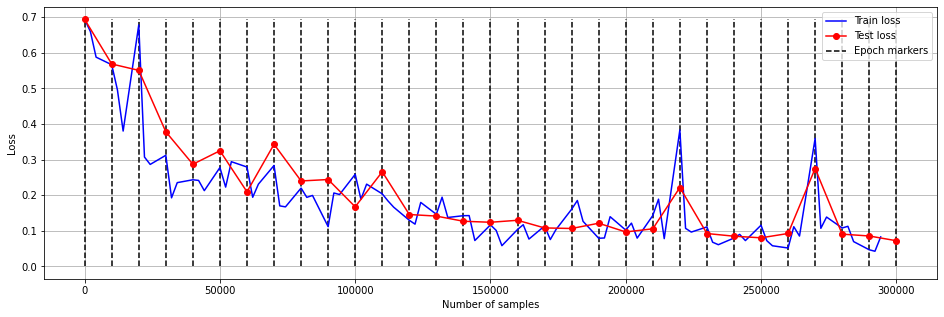

In [ ]:
# plot the train loss, test loss and epoch markers
fig = plt.figure(figsize=(16, 5))
plt.plot(train_counter, train_losses, color='blue', label='Train loss')
plt.plot(test_counter, test_losses, color='red',  marker='o', label='Test loss')
plt.vlines(test_counter, 0, max(train_losses + test_losses), linestyles='dashed', label='Epoch markers')

plt.legend(loc='upper right')
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.grid()

## Testing the results

In [ ]:
# create data loader for test set and let it go through the network
transform_test= T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])

model = torch.load("best_model")

test_ds = ImageFolder(root = TEST_DIR, transform = transform_test)
test_dl = DataLoader(test_ds, batch_size = 1, num_workers = 1, shuffle = False)

pred_class = []
images = [test_ds.imgs[i][0].split('/')[8] for i in range(len(test_ds.imgs))]

for batch_id, (data, target) in enumerate(test_dl):
  data = data.to(device)
  output = model(data)
  pred = output.data.max(1, keepdim=True)[1]
  pred_class.append(pred.item())

As it can be seen below, the model is not perfect - it sometimes mixes up classes - but in most cases it recognizes them well.

In [ ]:
print(images)
print(pred_class)
print(test_ds.imgs)

['1163.png', '1174.png', '1175.png', '1203.png', '1361.png', '1362.png', '1363.png', '1388.png', '1389.png', '1404.png', '1405.png', '1407.png', '1413.png', '1439.png', '147.png', '152.png', '153.png', '1558.png', '1559.png', '1565.png', '1573.png', '1606.png', '1607.png', '1611.png', '1612.png', '1767.png', '178.png', '1820.png', '1821.png', '1834.png', '1835.png', '1836.png', '187.png', '190.png', '219.png', '224.png', '225.png', '230.png', '231.png', '3.png', '350.png', '351.png', '385.png', '392.png', '393.png', '408.png', '422.png', '423.png', '45.png', '46.png', '51.png', '53.png', '542.png', '556.png', '557.png', '580.png', '595.png', '608.png', '609.png', '635.png', '740.png', '741.png', '742.png', '754.png', '768.png', '769.png', '782.png', '783.png', '79.png', '796.png', '807.png', '84.png', '85.png', '86.png', '90.png', '91.png', '92.png', '971.png', '998.png', 'Augmented_104_6573201.png', 'Augmented_105_2237800.png', 'Augmented_105_2879173.png', 'Augmented_106_3549951.png',